# Buildings Footprints

In this notebook, we explore the use of OpenStreetMap buildings footprints as built-up training samples. Two questions are investigated: (1) What is the data availability across our case studies? and (2) What percentage of a pixel has to be covered by buildings footprints to be safely considered as a built-up training sample?

## Imports & Parameters

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
from tqdm import tqdm_notebook as tqdm

In [2]:
# Add local module to the path
src = os.path.abspath('../src')
if src not in sys.path:
    sys.path.append(src)

In [3]:
from metadata import City, CITIES
from landsat import Scene
from raster import euclidean_distance

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
def pretty(city_id):
    """Format city label."""
    name = city_id.title()
    name = name.replace('_', '-')
    return name

In [6]:
# Plotting style
plt.style.use(['seaborn-paper', 'seaborn-whitegrid'])
plt.rc('font', family='serif', serif='cmr10', size=12)
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)
plt.rc('figure', titlesize=12)
plt.rc('savefig', dpi=300)
plt.rc('text', usetex=True)

## Data availability

Data availability can be expressed in terms of: (1) the number of objects (polygons), and (2) the total surface of the objects. Additionnaly, the median surface of the buildings footprints is computed for each case study in order to compare it to the surface of a Landsat pixel.

In [7]:
availability = pd.DataFrame(index=CITIES, columns=['Polygons', 'Total surface', 'Median surface'])
progress = tqdm(total=len(CITIES))

for city_name in CITIES:
    
    city = City(city_name)
    buildings = city.buildings
    availability.at[(city_name, 'Polygons')] = len(buildings)
    availability.at[(city_name, 'Total surface')] = buildings.area.sum() * 1e-4  # In hectares
    availability.at[(city_name, 'Median surface')] = np.median(buildings.area)  # In m2
    progress.update(1)

progress.close()

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [8]:
availability

,Polygons,Total surface,Median surface
antananarivo,17635,305.18,56.9071
chimoio,151882,701.513,31.0344
dakar,82653,1471.84,121.898
gao,7043,64.8374,59.166
johannesburg,6724,1613.2,553.471
kampala,228469,3013.12,77.1669
katsina,110,33.7746,257.218
nairobi,54857,1669.22,57.5225
saint_louis,24788,402.932,73.14
windhoek,2636,167.885,219.911


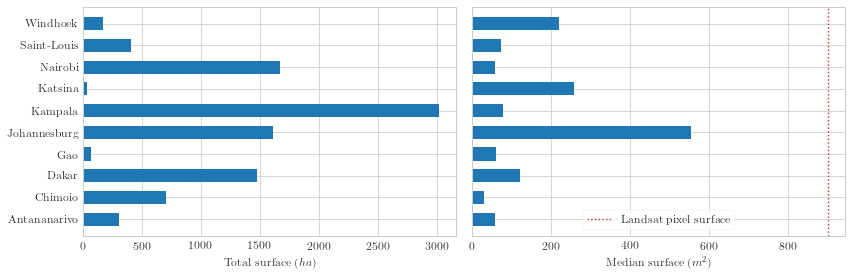

In [9]:
f, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

x = np.arange(len(availability.index))
heights = availability['Total surface']
width = 0.6
axes[0].barh(x, heights, width)
axes[0].set_yticks(x)
axes[0].set_yticklabels([pretty(city) for city in availability.index])
axes[0].set_xlabel('Total surface ($ha$)')

heights = availability['Median surface']
axes[1].barh(x, heights, width)
axes[1].set_xlabel('Median surface ($m^2$)')
axes[1].axvline(x=900, color='C3', linestyle=':', label='Landsat pixel surface')
axes[1].legend(frameon=True)

f.tight_layout()
f.savefig('../paper/figures/buildings_availability.png')
f.savefig('../paper/figures/buildings_availability.pdf');

The analysis suggests that data availability is not consistent across the case studies. It could be an issue in Katsina, Gao or Windhoek where very few buildings footprints are available. Additionnaly, the median surface of a building footprint is lower than 10% for the surface of a Landsat pixel. What is the relationship between the percentage of a pixel surface covered by a building footprint and its spectral characteristics?

## Minimum coverage

The objective of the following analysis is to find the optimal `min. coverage` threshold to use when rasterizing the buildings footprints. What percentage of a pixel has to be covered by footprints to be safely considered as a built-up training sample? This analysis makes use of the **spectral distance** concept to study the relationship between the `min. coverage` threshold and its influence on the resulting spectral characteristics. More specifically, we compare the **spectral signatures** of both the reference built-up samples (from a hand-digitized reference data set) and the rasterized building footprints depending on the `min. coverage` threshold. The euclidean spectral distance between both spectral signatures is defined by the following equation:

$d(x,y) = \sqrt{\sum_{i=1}^n (x_i - y_i)^2}$

with $x$ and $y$ being the spectral signatures of the reference and training pixels, and $n$ the number of bands (6 in the case of Landsat when excluding thermal bands).

In [10]:
min_cover_values = np.arange(0, 1.1, 0.1)
spectral_distance = pd.DataFrame(index=CITIES, columns=min_cover_values)
samples_count = pd.DataFrame(index=CITIES, columns=min_cover_values)

progress = tqdm(total=len(CITIES) * len(min_cover_values))

for city_name in CITIES:
    
    city = City(city_name)
    scene = Scene(city.landsat_dir)
    
    bu = city.reference == 1
    sign_ref = scene.signature(bu)
    
    cover = city.buildings_cover
    
    for min_cover in min_cover_values:
        
        buildings = (cover > 0) & (cover >= min_cover)
        sign_y = scene.signature(buildings)
        dist = euclidean_distance(sign_y, sign_ref)
        spectral_distance.at[(city_name, min_cover)] = dist
        samples_count.at[(city_name, min_cover)] = np.count_nonzero(buildings)
        progress.update(1)

progress.close()

HBox(children=(IntProgress(value=0, max=110), HTML(value='')))

In [11]:
spectral_distance

,0.0,0.1,0.2,0.30000000000000004,0.4,0.5,0.6000000000000001,0.7000000000000001,0.8,0.9,1.0
antananarivo,0.0123122,0.00577125,0.00451722,0.0155243,0.0279316,0.0423667,0.0600107,0.068081,0.0753559,0.0824193,0.0814498
chimoio,0.0437116,0.0174013,0.00783616,0.0257361,0.0432812,0.0547452,0.0492551,0.0532485,0.0539606,0.0522997,0.0529621
dakar,0.0857949,0.0765703,0.0653796,0.0510646,0.0397392,0.0287737,0.0258684,0.0244363,0.0297299,0.0321247,0.0387634
gao,0.0877078,0.0700043,0.057372,0.055735,0.0619408,0.0695283,0.0886424,0.117297,0.132019,0.126996,0.0937516
johannesburg,0.0810174,0.0958277,0.110028,0.127472,0.141096,0.155557,0.172297,0.187243,0.199448,0.213194,0.22776
kampala,0.0408819,0.0337176,0.0273562,0.021024,0.0162157,0.0136834,0.0216423,0.0329089,0.0409181,0.0506686,0.0606128
katsina,0.129463,0.130658,0.132996,0.139341,0.14059,0.143065,0.137476,0.132666,0.132509,0.132517,0.13326
nairobi,0.0237437,0.0169192,0.0122393,0.0125286,0.0170035,0.0235233,0.032031,0.0416724,0.0505256,0.0577647,0.0621755
saint_louis,0.0238324,0.0236985,0.0253153,0.0289377,0.0334501,0.0419343,0.0538236,0.0644714,0.0726063,0.0807464,0.0900292
windhoek,0.0340772,0.0279291,0.0349912,0.0581107,0.0817859,0.10805,0.148979,0.181041,0.202607,0.234837,0.27589


In [12]:
samples_count

,0.0,0.1,0.2,0.30000000000000004,0.4,0.5,0.6000000000000001,0.7000000000000001,0.8,0.9,1.0
antananarivo,13982,9552,6424,4041,2697,1723,1123,780,590,398,242
chimoio,82431,28513,9760,3176,1512,799,385,234,163,117,73
dakar,51418,41185,32209,23154,16667,10860,6317,3729,2278,1506,991
gao,6057,2774,1095,402,192,83,34,17,10,6,1
johannesburg,37251,30973,26313,21884,19095,16271,13572,11451,9866,8084,5961
kampala,139882,100807,67588,37751,21136,10538,5344,3437,2597,1970,1477
katsina,573,503,454,397,378,351,333,307,304,297,293
nairobi,45126,36702,30228,23814,19534,15522,11951,9156,7173,5558,3918
saint_louis,15397,11542,8394,5644,3895,2507,1729,1359,1144,980,807
windhoek,5507,4201,3212,2292,1823,1390,1026,780,618,461,300


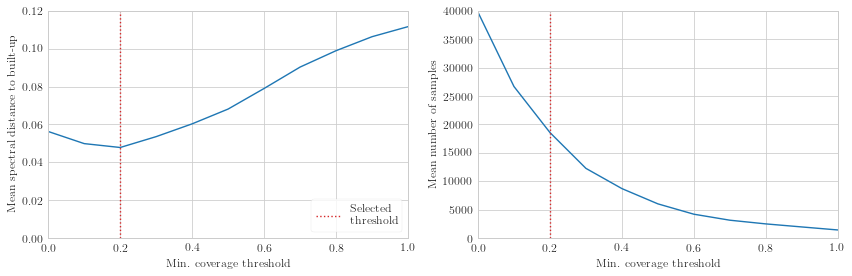

In [13]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(spectral_distance.mean(axis=0))
axes[0].axvline(x=0.2, color='C3', linestyle=':', label='Selected\nthreshold')
axes[0].set_xlim(0, 1.0)
axes[0].set_ylim(0, 0.12)
axes[0].legend(frameon=True)
axes[0].set_xlabel('Min. coverage threshold')
axes[0].set_ylabel('Mean spectral distance to built-up')

axes[1].plot(samples_count.mean(axis=0))
axes[1].axvline(x=0.2, color='C3', linestyle=':')
axes[1].set_xlim(0, 1.0)
axes[1].set_ylim(0, 40000)
axes[1].set_xlabel('Min. coverage threshold')
axes[1].set_ylabel('Mean number of samples')

f.tight_layout()
f.savefig('../paper/figures/buildings_mincov.pdf')
f.savefig('../paper/figures/buildings_mincov.png');

The first graph shows the mean spectral distance to the reference built-up spectral signature across all case studies depending on the `min. coverage` threshold. It suggests that using a low threshold (~ 0.2) reduces the spectral distance between the reference and the training samples. Surprisingly, using a higher threshold appears to increase the spectral distance. As shown in the second graph, the number of available samples is highly reduces when the `min. coverage` threshold increases. This suggests that applying a high threshold could reduce the quality of the training pixels because of the reduced sample size that reduces the representativeness.

Overall, the trade-off between training samples quality and quantity appears to be between 0.1 and 0.2.